Epoch #1


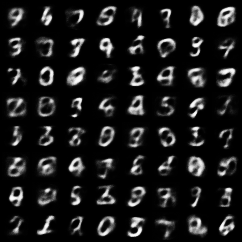



Epoch #2


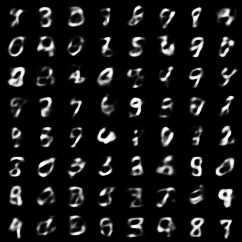



Epoch #3


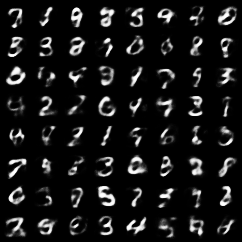



Epoch #4


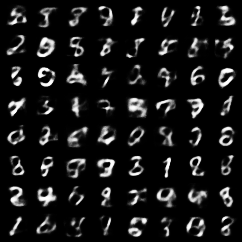



Epoch #5


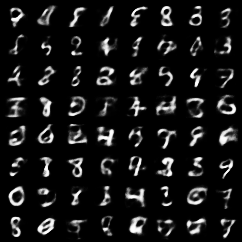



Epoch #6


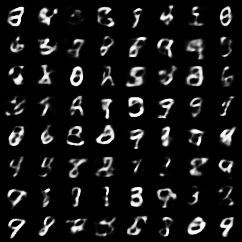



Epoch #7


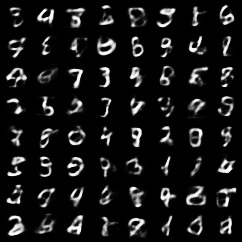



Epoch #8


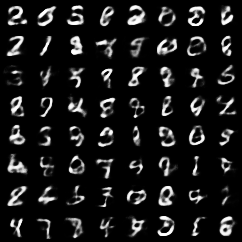



Epoch #9


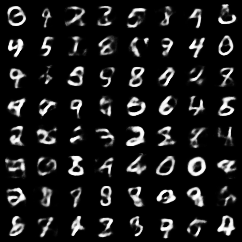



Epoch #10


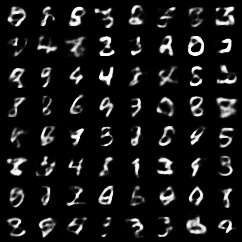



Epoch #11


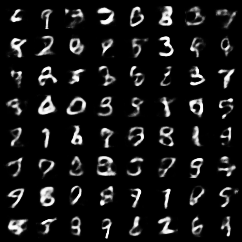



Epoch #12


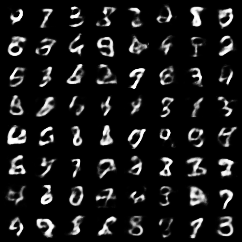



Epoch #13


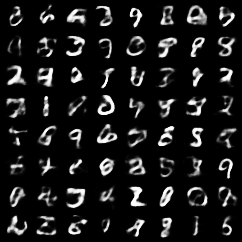



Epoch #14


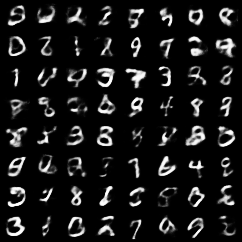

KeyboardInterrupt: 

In [27]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os

if not os.path.exists('results'):
    os.mkdir('results')

batch_size = 100
latent_size = 20

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.en_FC_input = nn.Linear(784, 400)
        self.en_FC_mean  = nn.Linear(400, latent_size)
        self.en_FC_var   = nn.Linear (400, latent_size)
        self.en_ReLU = nn.ReLU()

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        #The encoder will take an input of size 784, and will produce two vectors of size latent_size (corresponding to the coordinatewise means and log_variances)
        #It should have a single hidden linear layer with 400 nodes using ReLU activations, and have two linear output layers (no activations)
        h_ = self.en_ReLU(self.en_FC_input(x))
        means = self.en_FC_mean(h_)
        log_variances = self.en_FC_var(h_)
        return means, log_variances

    def reparameterize(self, means, log_variances):
        #The reparameterization module lies between the encoder and the decoder
        #It takes in the coordinatewise means and log-variances from the encoder (each of dimension latent_size), and returns a sample from a Gaussian with the corresponding parameters
        std = torch.exp(log_variances * 0.5).to(device)
        eps = torch.randn_like(std).to(device)
        return means + eps * std

    def decode(self, z):
        #The decoder will take an input of size latent_size, and will produce an output of size 784
        #It should have a single hidden linear layer with 400 nodes using ReLU activations, and use Sigmoid activation for its outputs
        res = self.decoder(z)
        return res

    def forward(self, x):
        #Apply the VAE encoder, reparameterization, and decoder to an input of size 784
        #Returns an output image of size 784, as well as the means and log_variances, each of size latent_size (they will be needed when computing the loss)
        means, log_variances = self.encode(x)
        z = self.reparameterize(means, log_variances)
        res = self.decode(z)
        return res, means, log_variances

def vae_loss_function(reconstructed_x, x, means, log_variances):
    #Compute the VAE loss
    #The loss is a sum of two terms: reconstruction error and KL divergence
    #Use cross entropy loss between x and reconstructed_x for the reconstruction error (as opposed to L2 loss as discussed in lecture -- this is sometimes done for data in [0,1] for easier optimization)
    #The KL divergence is -1/2 * sum(1 + log_variances - means^2 - exp(log_variances)) as described in lecture
    #Returns loss (reconstruction + KL divergence) and reconstruction loss only (both scalars)
    reconstruction_loss = torch.nn.functional.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_variances - means ** 2 - torch.exp(log_variances))
    loss = reconstruction_loss + kl_loss
    return loss, reconstruction_loss


def train(model, optimizer):
    #Trains the VAE for one epoch on the training dataset
    #Returns the average (over the dataset) loss (reconstruction + KL divergence) and reconstruction loss only (both scalars)
    model.train()

    running_loss = 0
    running_construction_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 784)
        data = data.to(device)
        optimizer.zero_grad()
        reconstucted_x, means, log_variances = model.forward(data)
        loss, reconstruction_loss = vae_loss_function(reconstucted_x, data, means, log_variances)
        running_loss += loss.item()
        running_construction_loss += reconstruction_loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = running_loss / len(train_loader)
    avg_train_reconstruction_loss = running_construction_loss / len(train_loader)
    return avg_train_loss, avg_train_reconstruction_loss

def test(model):
    #Runs the VAE on the test dataset
    #Returns the average (over the dataset) loss (reconstruction + KL divergence) and reconstruction loss only (both scalars)
    model.eval()
    running_loss = 0
    running_construction_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.view(-1, 784)
            data = data.to(device)
            reconstucted_x, means, log_variances = model(data)
            loss, reconstruction_loss = vae_loss_function(reconstucted_x, data, means, log_variances)
            running_loss += loss.item()
            running_construction_loss += reconstruction_loss.item()
    avg_test_loss = running_loss / len(test_loader)
    avg_test_reconstruction_loss = running_construction_loss / len(test_loader)
    return avg_test_loss, avg_test_reconstruction_loss

if __name__ == '__main__':
    epochs = 50
    avg_train_losses = []
    avg_train_reconstruction_losses = []
    avg_test_losses = []
    avg_test_reconstruction_losses = []

    vae_model = VAE().to(device)
    vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

    for epoch in range(1, epochs + 1):
        avg_train_loss, avg_train_reconstruction_loss = train(vae_model, vae_optimizer)
        avg_test_loss, avg_test_reconstruction_loss = test(vae_model)
        
        avg_train_losses.append(avg_train_loss)
        avg_train_reconstruction_losses.append(avg_train_reconstruction_loss)
        avg_test_losses.append(avg_test_loss)
        avg_test_reconstruction_losses.append(avg_test_reconstruction_loss)

        with torch.no_grad():
            sample = torch.randn(64, latent_size).to(device)
            sample = vae_model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')
            print('Epoch #' + str(epoch))
            display(Image('results/sample_' + str(epoch) + '.png'))
            print('\n')

    plt.plot(avg_train_reconstruction_losses)
    plt.title('Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch #')
    plt.show()

    plt.plot(avg_test_reconstruction_losses)
    plt.title('Test Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch #')
    plt.show()
